In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from typing import Literal, Tuple

In [4]:
def calculate_distance_sq(point1: np.ndarray, point2: np.ndarray) -> float:
    """Calculates the squared Euclidean distance between two points."""
    return np.sum((point1 - point2)**2)

def initialize_centroids_random(X: np.ndarray, k: int, seed: int) -> np.ndarray:
    """
    Initializes centroids by randomly choosing k points from X (Forgy method).
    [Requirement 1 - Forgy initialization]
    """
    rng = np.random.default_rng(seed)
    random_indices = rng.choice(X.shape[0], size=k, replace=False)
    centroids = X[random_indices]
    return centroids

In [5]:
def initialize_centroids_kmeans_plus_plus(X: np.ndarray, k: int, seed: int) -> np.ndarray:
    """
    Initializes centroids using the K-Means++ method.
    [Core Requirement 2 - K-Means++ initialization]
    """
    rng = np.random.default_rng(seed)
    n_samples = X.shape[0]
    centroids = np.zeros((k, X.shape[1]))

    # 1. Choose the first centroid uniformly at random from the data points.
    first_centroid_idx = rng.choice(n_samples)
    centroids[0] = X[first_centroid_idx]

    # 2. For each subsequent centroid:
    for i in range(1, k):
        # a. For each data point, calculate D(x)^2 to the nearest already chosen centroid.
        dist_sq_to_nearest_centroid = np.array([min([calculate_distance_sq(x, c) for c in centroids[:i]]) for x in X])

        # b. Choose the next centroid from the data points with probability proportional to D(x)^2.
        probabilities = dist_sq_to_nearest_centroid / np.sum(dist_sq_to_nearest_centroid)
        if np.all(probabilities == 0): # Handle case where all distances are zero (e.g. duplicate points)
             next_centroid_idx = rng.choice(n_samples, p=(np.ones(n_samples) / n_samples) )
        else:
            next_centroid_idx = rng.choice(n_samples, p=probabilities)
        centroids[i] = X[next_centroid_idx]
    return centroids

def assign_labels(X: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    """Assigns each data point to the nearest centroid."""
    labels = np.zeros(X.shape[0], dtype=int)
    for i, point in enumerate(X):
        distances_sq = [calculate_distance_sq(point, centroid) for centroid in centroids]
        labels[i] = np.argmin(distances_sq)
    return labels

def update_centroids(X: np.ndarray, labels: np.ndarray, k: int) -> np.ndarray:
    """Recalculates centroids as the mean of all data points assigned to that cluster."""
    new_centroids = np.zeros((k, X.shape[1]))
    for i in range(k):
        points_in_cluster = X[labels == i]
        if len(points_in_cluster) > 0:
            new_centroids[i] = np.mean(points_in_cluster, axis=0)
        else:
            # Simpler approach for this function: if points_in_cluster is empty,
            # that centroid position new_centroids[i] will remain zero or its previous value
            # if initialized from old centroids.
            # Let's pass previous centroids to handle this.
            pass # The main function will handle copying old centroid if cluster is empty
    return new_centroids
def calculate_inertia(X: np.ndarray, labels: np.ndarray, centroids: np.ndarray) -> float:
    """
    Calculates the inertia (sum of squared distances to the nearest cluster center).
    [Requirement 3 - Inertia Calculation]
    """
    inertia = 0.0
    for i in range(len(X)):
        inertia += calculate_distance_sq(X[i], centroids[labels[i]])
    return inertia

In [6]:
def kmeans(X: np.ndarray, k: int, max_iter: int = 100, tol: float = 1e-4, seed: int = 42,
           init: Literal["random", "kmeans_plus_plus"] = "kmeans_plus_plus") -> Tuple[np.ndarray, np.ndarray, int, float]:
    """
    Performs K-Means clustering.
    [Requirement 1 & 2 - K-Means function with random and K-Means++ init]
    """
    # Initialize centroids
    if init == "random":
        current_centroids = initialize_centroids_random(X, k, seed)
    elif init == "kmeans_plus_plus":
        current_centroids = initialize_centroids_kmeans_plus_plus(X, k, seed)
    else:
        raise ValueError("Invalid initialization method. Choose 'random' or 'kmeans_plus_plus'.")

    iterations = 0
    for i in range(max_iter):
        iterations += 1
        # Assignment step
        labels = assign_labels(X, current_centroids)

        # Update step
        # Create new_centroids based on current_centroids to handle empty clusters
        new_centroids = current_centroids.copy() # Start with old centroids
        for j in range(k):
            points_in_cluster = X[labels == j]
            if len(points_in_cluster) > 0:
                new_centroids[j] = np.mean(points_in_cluster, axis=0)
            # If cluster is empty, its centroid (new_centroids[j]) remains as it was (copied from current_centroids)
            # This is a common way to handle empty clusters, preventing them from disappearing or causing errors.

        # Check for convergence
        centroid_shift = np.sum((new_centroids - current_centroids)**2)
        current_centroids = new_centroids

        if centroid_shift < tol:
            # print(f"Converged in {iterations} iterations for init='{init}', k={k}.")
            break
    else: # Executed if the loop completed without break (max_iter reached)
        # print(f"Reached max_iter={max_iter} for init='{init}', k={k}.")
        pass

    inertia = calculate_inertia(X, labels, current_centroids)
    return current_centroids, labels, iterations, inertia

In [7]:
# --- Core Requirement 3: Test on Iris Dataset ---
def load_iris_data(file_path: str) -> Tuple[pd.DataFrame, np.ndarray, np.ndarray, list, list]:
    """Loads the Iris dataset and prepares it for clustering."""
    try:
        iris_df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: Iris dataset not found at {file_path}")
        print("Please ensure the file path is correct and the Iris.csv file is present.")
        return None, None, None, None, None

    # Assuming the CSV has columns like 'SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', 'Species'
    # Or similar names. Let's try to be a bit robust or user might need to adjust this.
    # For project requirement, let's assume standard column names or first 4 are features and last is target
    feature_columns = iris_df.columns[:-1] # Assume last column is Species/target
    target_column = iris_df.columns[-1]

    X_iris = iris_df[feature_columns].values
    y_iris_str = iris_df[target_column].values
    
    # Convert string labels to integers for easier plotting if needed
    species_names = np.unique(y_iris_str)
    label_map = {species: i for i, species in enumerate(species_names)}
    y_iris_int = np.array([label_map[s] for s in y_iris_str])
    
    return iris_df, X_iris, y_iris_int, list(feature_columns), list(species_names)

def plot_iris_pca(X_pca: np.ndarray, labels: np.ndarray, title: str, class_names: list = None, centroids_pca: np.ndarray = None):
    """Plots 2D PCA of Iris data with given labels and optional centroids."""
    plt.figure(figsize=(10, 7))
    unique_labels = np.unique(labels)
    colors = sns.color_palette("viridis", n_colors=len(unique_labels))

    for i, label in enumerate(unique_labels):
        points = X_pca[labels == label]
        legend_label = str(class_names[label]) if class_names and label < len(class_names) else f'Cluster {label}'
        plt.scatter(points[:, 0], points[:, 1], color=colors[i], label=legend_label, alpha=0.7)

    if centroids_pca is not None:
        plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='X', s=200, color='red', label='Centroids', edgecolor='black')

    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()


Iris dataset loaded: 150 samples, 5 features.
Feature names: ['Id', 'SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
Species (true labels): ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']



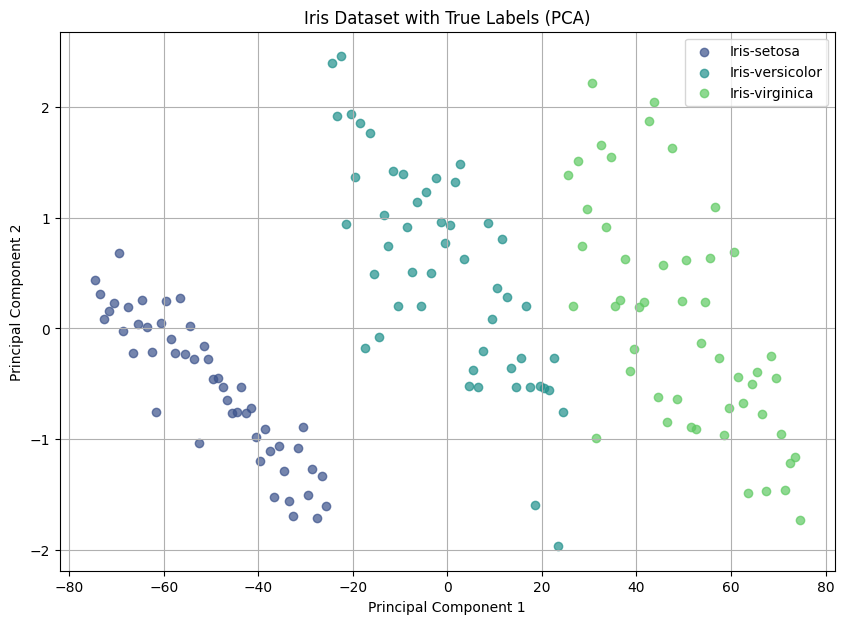


--- Running K-Means (random init) for k=3 ---
Random Init: Converged in 7 iterations. Inertia: 31370.0160


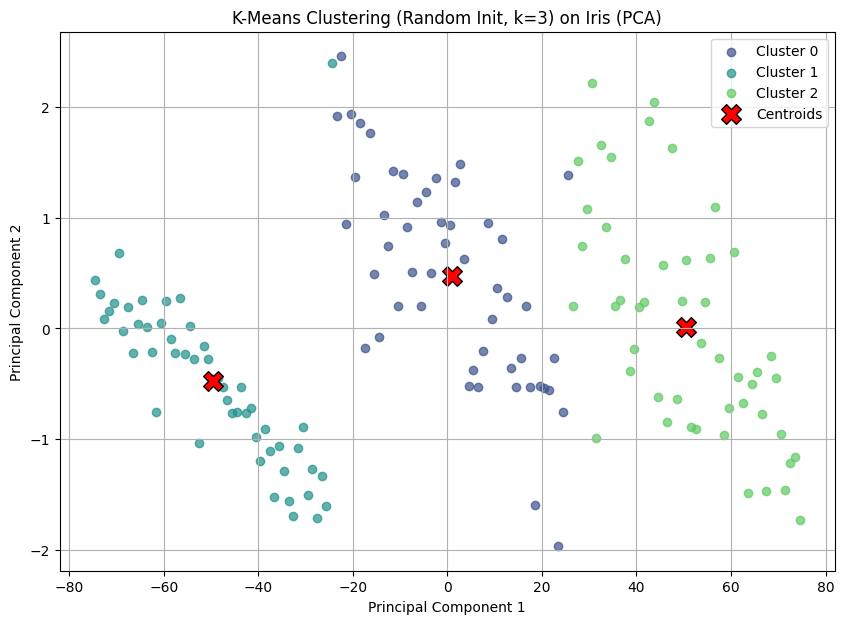


--- Running K-Means (K-Means++ init) for k=3 ---
K-Means++ Init: Converged in 6 iterations. Inertia: 31370.0160


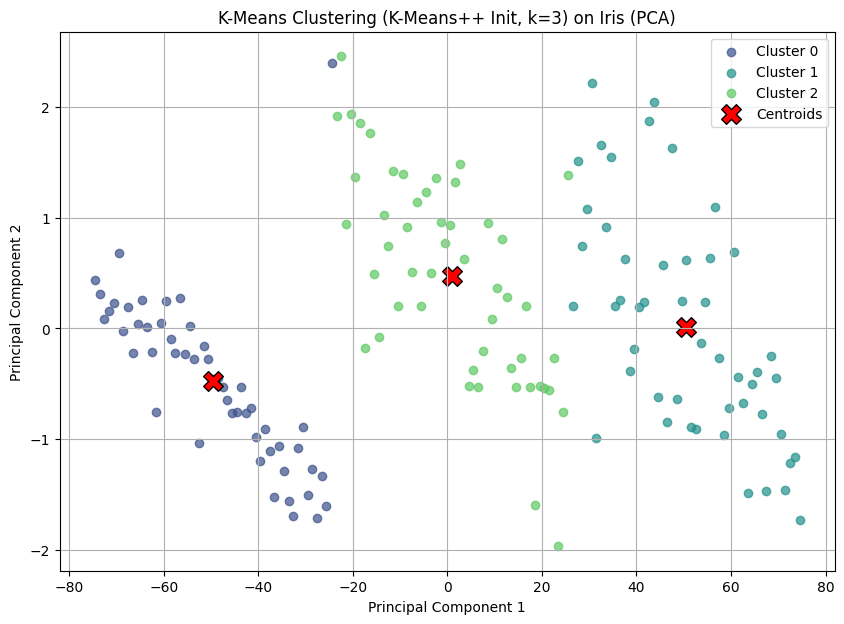


--- Inertia Analysis (Elbow Method) ---
k=1: Random Inertia=281918.32 (iters:2), K-Means++ Inertia=281918.32 (iters:2)
k=2: Random Inertia=70649.35 (iters:6), K-Means++ Inertia=70649.35 (iters:6)
k=3: Random Inertia=31370.02 (iters:7), K-Means++ Inertia=31370.02 (iters:6)
k=4: Random Inertia=17810.13 (iters:4), K-Means++ Inertia=17813.24 (iters:6)
k=5: Random Inertia=11471.89 (iters:8), K-Means++ Inertia=11598.28 (iters:9)
k=6: Random Inertia=8227.30 (iters:25), K-Means++ Inertia=7983.56 (iters:11)
k=7: Random Inertia=6155.54 (iters:34), K-Means++ Inertia=6155.54 (iters:15)
k=8: Random Inertia=4948.69 (iters:20), K-Means++ Inertia=4948.69 (iters:18)
k=9: Random Inertia=4267.58 (iters:21), K-Means++ Inertia=3738.98 (iters:13)
k=10: Random Inertia=2989.68 (iters:6), K-Means++ Inertia=3002.37 (iters:9)


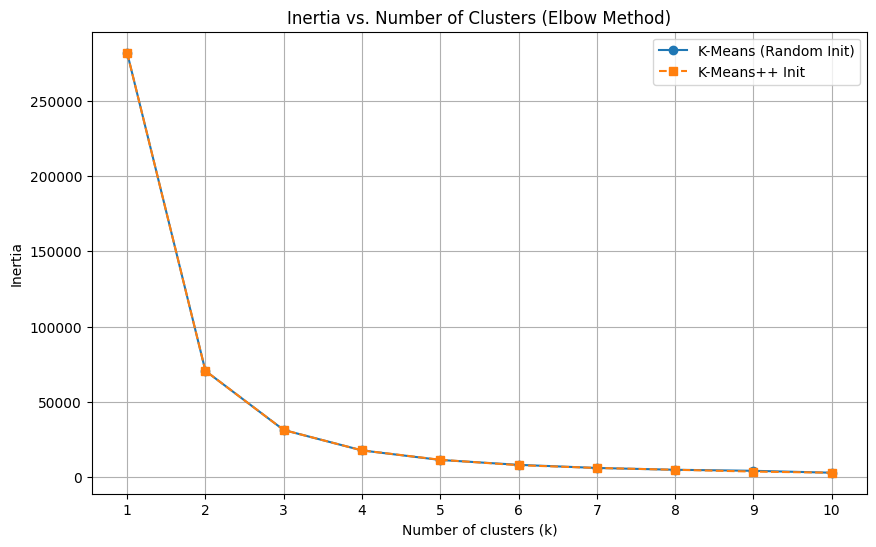


--- Convergence Analysis (Iterations for k=3) ---
Method         | Iterations (k=3) | Inertia (k=3)
---------------|--------------------|-----------------
K-Means Random | 7                  | 31370.0160     
K-Means++      | 6                  | 31370.0160     

--- Iteration Comparison for different k values ---
k | Iterations (Random) | Iterations (K-Means++)
--|---------------------|-------------------------
1 | 2                   | 2                      
2 | 6                   | 6                      
3 | 7                   | 6                      
4 | 4                   | 6                      
5 | 8                   | 9                      
6 | 25                  | 11                     
7 | 34                  | 15                     
8 | 20                  | 18                     
9 | 21                  | 13                     
10| 6                   | 9                      


In [8]:
def main():
    iris_file_path = r"F:\25春资料\数据挖掘技术\project\project3kmeans\Iris.csv" # Use raw string for Windows paths
    iris_df, X_iris, y_iris_true_labels, feature_names, species_names = load_iris_data(iris_file_path)

    if X_iris is None:
        return

    print(f"Iris dataset loaded: {X_iris.shape[0]} samples, {X_iris.shape[1]} features.")
    print(f"Feature names: {feature_names}")
    print(f"Species (true labels): {species_names}\n")

    # Data Exploration: Visualize with PCA [Requirement 3 - Data exploration]
    pca = PCA(n_components=2, random_state=42)
    X_iris_pca = pca.fit_transform(X_iris)
    plot_iris_pca(X_iris_pca, y_iris_true_labels, 'Iris Dataset with True Labels (PCA)', class_names=species_names)

    k_iris = 3 # Iris dataset has 3 species [cite: 11]

    # Run K-Means with random initialization
    print(f"\n--- Running K-Means (random init) for k={k_iris} ---")
    centroids_random, labels_random, iterations_random, inertia_random = kmeans(X_iris, k=k_iris, seed=42, init="random")
    print(f"Random Init: Converged in {iterations_random} iterations. Inertia: {inertia_random:.4f}")
    # print("Random Init Centroids:\n", centroids_random)
    centroids_random_pca = pca.transform(centroids_random)
    plot_iris_pca(X_iris_pca, labels_random, f'K-Means Clustering (Random Init, k={k_iris}) on Iris (PCA)', centroids_pca=centroids_random_pca)

    # Run K-Means with K-Means++ initialization
    print(f"\n--- Running K-Means (K-Means++ init) for k={k_iris} ---")
    centroids_plus, labels_plus, iterations_plus, inertia_plus = kmeans(X_iris, k=k_iris, seed=42, init="kmeans_plus_plus")
    print(f"K-Means++ Init: Converged in {iterations_plus} iterations. Inertia: {inertia_plus:.4f}")
    # print("K-Means++ Init Centroids:\n", centroids_plus)
    centroids_plus_pca = pca.transform(centroids_plus)
    plot_iris_pca(X_iris_pca, labels_plus, f'K-Means Clustering (K-Means++ Init, k={k_iris}) on Iris (PCA)', centroids_pca=centroids_plus_pca)

    # Inertia Analysis (Elbow Method) [Requirement 3 - Inertia analysis]
    print("\n--- Inertia Analysis (Elbow Method) ---")
    k_values = range(1, 11)
    inertias_random = []
    iterations_list_random = []
    inertias_plus = []
    iterations_list_plus = []

    for k_val in k_values:
        _, _, iter_r, inertia_r = kmeans(X_iris, k=k_val, seed=42, init="random", max_iter=300) # max_iter increased for elbow stability
        inertias_random.append(inertia_r)
        iterations_list_random.append(iter_r)

        _, _, iter_p, inertia_p = kmeans(X_iris, k=k_val, seed=42, init="kmeans_plus_plus", max_iter=300)
        inertias_plus.append(inertia_p)
        iterations_list_plus.append(iter_p)
        print(f"k={k_val}: Random Inertia={inertia_r:.2f} (iters:{iter_r}), K-Means++ Inertia={inertia_p:.2f} (iters:{iter_p})")


    plt.figure(figsize=(10, 6))
    plt.plot(k_values, inertias_random, marker='o', linestyle='-', label='K-Means (Random Init)')
    plt.plot(k_values, inertias_plus, marker='s', linestyle='--', label='K-Means++ Init')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Inertia vs. Number of Clusters (Elbow Method)')
    plt.xticks(list(k_values))
    plt.legend()
    plt.grid(True)
    plt.show()

    # Convergence Analysis (Iterations) [Requirement 3 - Convergence analysis]
    print("\n--- Convergence Analysis (Iterations for k=3) ---")
    # Results for k=3 already printed above, let's formalize into a table-like output
    print(f"Method         | Iterations (k={k_iris}) | Inertia (k={k_iris})")
    print(f"---------------|--------------------|-----------------")
    print(f"K-Means Random | {iterations_random:<18} | {inertia_random:<15.4f}")
    print(f"K-Means++      | {iterations_plus:<18} | {inertia_plus:<15.4f}")

    # Comparison table for iterations across different k values (from elbow analysis)
    print("\n--- Iteration Comparison for different k values ---")
    print("k | Iterations (Random) | Iterations (K-Means++)")
    print("--|---------------------|-------------------------")
    for i, k_val in enumerate(k_values):
        print(f"{k_val:<2}| {iterations_list_random[i]:<19} | {iterations_list_plus[i]:<23}")

if __name__ == '__main__':
    main()

In [9]:
import pandas as pd

# 加载数据
df = pd.read_csv("F:/25春资料/数据挖掘技术/project/project3kmeans/Iris.csv")

# 删除 ID 列（如果存在）
if 'Id' in df.columns:
    df = df.drop(columns=['Id'])

# 特征矩阵
X = df.drop(columns=['Species']).values


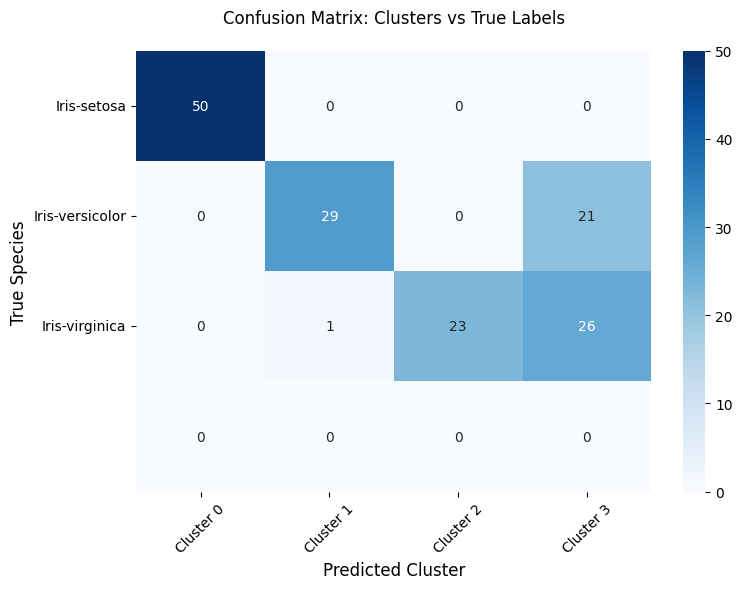

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# 假设 df 是包含数据的 DataFrame，X 是特征矩阵
# ----------------------------------------------
# 步骤1：标签编码（真实标签转数字）
le = LabelEncoder()
true_labels = le.fit_transform(df['Species'])

# 步骤2：执行聚类（需确保kmeans函数返回标签）
# 修改点1：正确解包返回值（假设kmeans返回4个值：质心、标签、SSE、迭代次数）
centroids, predicted_labels, _, _ = kmeans(X, k=4, init='kmeans_plus_plus')

# 步骤3：生成混淆矩阵
# 修改点2：输入参数顺序应为 (真实标签, 预测标签)
cm = confusion_matrix(true_labels, predicted_labels)

# 步骤4：可视化（解决维度不匹配问题）
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    # 修改点3：xticklabels数量与聚类数k=4一致
    xticklabels=[f'Cluster {i}' for i in range(4)],  # 原代码中的3改为4
    # yticklabels数量与真实类别数一致（假设Species有3类）
    yticklabels=le.classes_  
)
plt.xlabel('Predicted Cluster', fontsize=12)
plt.ylabel('True Species', fontsize=12)
plt.title('Confusion Matrix: Clusters vs True Labels', pad=20)
plt.xticks(rotation=45)  # 避免簇标签重叠
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

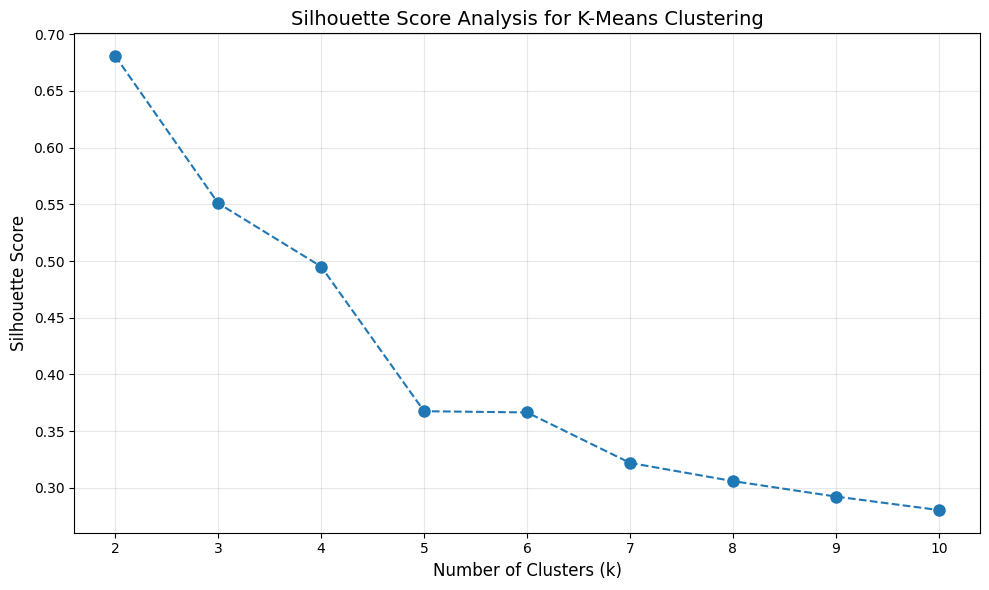

In [18]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 计算不同k值下的轮廓系数
silhouette_scores = []
k_range = range(2, 11)  # 轮廓系数不支持k=1

for k in k_range:
    # 修改点1：正确解包返回值（假设kmeans返回4个值：质心、标签、SSE、迭代次数）
    centroids, labels, _, _ = kmeans(X, k, init='kmeans_plus_plus')  # 解包4个返回值
    
    # 计算当前k值的轮廓系数
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

# 可视化结果（优化绘图参数）
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o', markersize=8, linestyle='--', linewidth=1.5)
plt.title("Silhouette Score Analysis for K-Means Clustering", fontsize=14)
plt.xlabel("Number of Clusters (k)", fontsize=12)
plt.ylabel("Silhouette Score", fontsize=12)
plt.xticks(k_range)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()